In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
import re
import os
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
MAX_SEQUENCE_LENGTH = 220
SEED = 1234
EPOCHS = 1
Data_dir="../jigsaw-dataset"
WORK_DIR = "../working/"
num_to_load=1000000                         #Train size to match time limit
valid_size= 100000                          #Validation Size
TOXICITY_COLUMN = 'target'

In [4]:
def convert_lines(example, max_seq_length,tokenizer):
    max_seq_length -=2
    all_tokens = []
    longer = 0
    for text in tqdm_notebook(example):
        tokens_a = tokenizer.tokenize(text)
        if len(tokens_a)>max_seq_length:
            tokens_a = tokens_a[:max_seq_length]
            longer += 1
        one_token = tokenizer.convert_tokens_to_ids(["[CLS]"]+tokens_a+["[SEP]"])+[0] * (max_seq_length - len(tokens_a))
        all_tokens.append(one_token)
    print(longer)
    return np.array(all_tokens)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [6]:
# Load the training data
train = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Clean the text data
train['comment_text'] = train['comment_text'].replace({r'\s+$': '', r'^\s+': ''}, regex=True).replace(r'\n', ' ', regex=True)

# Add class labels (binary: 0 for non-toxic, 1 for toxic)
train['label'] = np.where(train['target'] >= 0.5, 1, 0)

# Retain only necessary columns
train = train[['id', 'comment_text', 'label']]

# Sample a 10% subset for demonstration
train_subset = train.sample(frac=0.1, random_state=42)

# Split into training and validation sets (80/20 split)
train_data, val_data = train_test_split(train_subset, test_size=0.2, stratify=train_subset['label'], random_state=42)

# Print data stats
print(f"Subset Training set size: {len(train_data)}")
print(f"Subset Validation set size: {len(val_data)}")

# Save the sampled training and validation sets
train_data.to_csv("train_subset.csv", index=False)
val_data.to_csv("val_subset.csv", index=False)

Subset Training set size: 144389
Subset Validation set size: 36098


In [7]:
# Drop rows with null comment_text
train_data = train_data.dropna(subset=['comment_text'])
val_data = val_data.dropna(subset=['comment_text'])

# Ensure all values are strings
train_data['comment_text'] = train_data['comment_text'].astype(str)
val_data['comment_text'] = val_data['comment_text'].astype(str)

# Check data again
print("Number of null values after cleaning:")
print("Train set:", train_data['comment_text'].isnull().sum())
print("Validation set:", val_data['comment_text'].isnull().sum())



Number of null values after cleaning:
Train set: 0
Validation set: 0


In [8]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize data function
def tokenize_data(data, text_column, label_column):
    encodings = tokenizer(
        list(data[text_column]),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = data[label_column].values
    return encodings, labels

# Tokenize training and validation data
train_encodings, train_labels = tokenize_data(train_data, "comment_text", "label")
val_encodings, val_labels = tokenize_data(val_data, "comment_text", "label")


In [9]:
import torch
from torch.utils.data import Dataset, DataLoader


class ToxicCommentsDataset(Dataset):
    def __init__(self, ids, encodings, labels):
        self.ids = ids  # Store ids for reference
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Only return id for reference, not for the model
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Add labels for the model
        item['id'] = self.ids[idx]  # Keep 'id' for external use only
        item['row_index'] = idx # Include the row index for dataset tracking
        return item


# Create datasets
train_dataset = ToxicCommentsDataset(train_data['id'].values, train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_data['id'].values, val_encodings, val_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [10]:
from transformers import BertForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm
import copy

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
second_model = copy.deepcopy(model)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
num_training_steps = len(train_loader) * 3  # Assuming 3 epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Training loop
epochs = 1
model.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(train_loader, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k not in ["id", "row_index"]}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/opt/conda/envs/toxic/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training:   0%|          | 0/9025 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 9025/9025 [24:01<00:00,  6.26it/s, loss=0.0832] 


In [11]:
from tqdm import tqdm
from sklearn.metrics import classification_report

# Evaluation loop
model.eval()
step = 0
error_indices = []

with torch.no_grad():
    loop = tqdm(train_loader, desc="Evaluating on Training Set", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id' and 'row_index'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        labels = batch["labels"].to(device) 
        row_indices = batch["row_index"]  

        outputs = model(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Identify misclassified samples
        masks = (preds != labels).cpu()
        wrong_indices = row_indices[masks]  
        error_indices += wrong_indices.tolist()

        step += 1


Evaluating on Training Set:   0%|          | 0/9025 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating on Training Set: 100%|██████████| 9025/9025 [08:06<00:00, 18.56it/s]


In [12]:
from torch.utils.data import Sampler
from typing import Iterator, List

class CustomIndicesSampler(Sampler[int]):
    """
    Samples from the specified indices (pass indices - upsampled, downsampled, group balanced etc. to this class)
    Default is no shuffle.
    """
    def __init__(
        self,
        indices: List[int],
        shuffle: bool = False,
    ):
        """
        Samples elements from the specified indices.

        :param indices: The list of indices to sample from.
        :type indices: list[int]
        :param shuffle: Whether to shuffle the indices. Default is False.
        :type shuffle: bool, optional
        """
        self.indices = indices
        self.shuffle = shuffle

    def __iter__(self) -> Iterator[int]:
        """
        Returns an iterator over the sampled indices.

        :return: An iterator over the sampled indices.
        :rtype: iterator[int]
        """
        if self.shuffle:
            random.shuffle(self.indices)
        return iter(self.indices)

    def __len__(self) -> int:
        """
        Returns the number of sampled indices.

        :return: The number of sampled indices.
        :rtype: int
        """
        return len(self.indices)

In [13]:
# Up sample for JTT

up_sample_weight = 5
indices = list(range(len(train_dataset))) + up_sample_weight * error_indices
copy_old_train_dataset = copy.deepcopy(train_dataset)
upsampled_loader = DataLoader(copy_old_train_dataset, batch_size = 16, sampler = CustomIndicesSampler(indices,True))

In [ ]:
print(f"Dataset size: {len(train_dataset)}")
print(f"Max index in error_indices: {max(error_indices)}")
print(f"Valid indices: {all(idx < len(train_dataset) for idx in error_indices)}")

# Train with the upsampled loader
second_model.to(device)

# Optimizer and learning rate scheduler
second_optimizer = AdamW(second_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
second_num_training_steps = len(upsampled_loader) * 3  # Assuming 3 epochs
second_lr_scheduler = get_scheduler("linear", optimizer=second_optimizer, num_warmup_steps=0, num_training_steps=second_num_training_steps)

# Training loop
epochs = 1
second_model.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(upsampled_loader, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = second_model(**batch)
        loss = outputs.loss
        loss.backward()
        second_optimizer.step()
        second_lr_scheduler.step()
        second_optimizer.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())


Dataset size: 144388
Max index in error_indices: 144330
Valid indices: True
Epoch 1/1


Training:   0%|          | 0/10978 [00:00<?, ?it/s]

/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 10978/10978 [29:16<00:00,  6.25it/s, loss=0.199]  


In [15]:
output_dir = "bert-model_checkpoint_10p_jtt"

second_model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('bert-model_checkpoint_10p_jtt/tokenizer_config.json',
 'bert-model_checkpoint_10p_jtt/special_tokens_map.json',
 'bert-model_checkpoint_10p_jtt/vocab.txt',
 'bert-model_checkpoint_10p_jtt/added_tokens.json')

In [26]:
output_dir = "bert-model_checkpoint_10p"

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('bert-model_checkpoint_10p/tokenizer_config.json',
 'bert-model_checkpoint_10p/special_tokens_map.json',
 'bert-model_checkpoint_10p/vocab.txt',
 'bert-model_checkpoint_10p/added_tokens.json')

In [16]:
from sklearn.metrics import classification_report

# Evaluation loop
second_model.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = model(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))

# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions.csv", index=False)
print("Validation predictions saved to 'val_with_predictions.csv'.")

Evaluating:   0%|          | 0/2257 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 2257/2257 [02:02<00:00, 18.44it/s]


              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.97     33207
       Toxic       0.78      0.51      0.61      2891

    accuracy                           0.95     36098
   macro avg       0.87      0.75      0.79     36098
weighted avg       0.94      0.95      0.94     36098

Validation predictions saved to 'val_with_predictions.csv'.


In [17]:
# Load original dataset
original_data = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Load validation predictions
val_predictions = pd.read_csv("val_with_predictions.csv")

In [18]:
# Merge validation predictions with the original dataset
merged_data = val_predictions.merge(original_data, on="id", how="left")

In [19]:
# Define subgroup columns
subgroups = [
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white"
]


In [20]:
# Initialize dictionary to store results
subgroup_accuracies = {}

# Calculate accuracy for each subgroup
for subgroup in subgroups:
    # Filter rows where the subgroup column is 1 (indicating membership in the subgroup)
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate accuracy: (correct predictions / total predictions for the subgroup)
        correct_predictions = (subgroup_data['true_label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        # Handle cases where there are no members in the subgroup
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert results to a DataFrame for better visualization
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]

# Sort the DataFrame by accuracy
subgroup_accuracies_df = subgroup_accuracies_df.sort_values(by="Accuracy", ascending=False)

# Display the results
print(subgroup_accuracies_df)

# Save the results to a CSV file
subgroup_accuracies_df.to_csv("subgroup_accuracies.csv", index=False)
print("Subgroup accuracies saved to 'subgroup_accuracies.csv'.")

                               Subgroup  Accuracy  Support
0                                 asian       0.0       19
1                               atheist       0.0        6
2                              bisexual       0.0        1
3                                 black       0.0      171
4                              buddhist       0.0        1
5                             christian       0.0      335
6                                female       0.0      593
7                          heterosexual       0.0        7
8                                 hindu       0.0        3
9             homosexual_gay_or_lesbian       0.0      100
11                               jewish       0.0       74
12                               latino       0.0       15
13                                 male       0.0      413
14                               muslim       0.0      266
18                       other_religion       0.0        2
21        psychiatric_or_mental_illness       0.0       

In [21]:
# Check the unique values of true_label and predicted_label
print("Unique values in true_label:", merged_data['true_label'].unique())
print("Unique values in predicted_label:", merged_data['predicted_label'].unique())

Unique values in true_label: [0 1]
Unique values in predicted_label: ['non-toxic' 'toxic']


In [22]:
# Ensure labels are numeric
merged_data['true_label'] = merged_data['true_label'].map({"non-toxic": 0, "toxic": 1})
merged_data['predicted_label'] = merged_data['predicted_label'].map({"non-toxic": 0, "toxic": 1})

In [23]:
# Check the counts of members in each subgroup
subgroup_counts = merged_data[subgroups].sum()
print(subgroup_counts)


asian                                    80.784453
atheist                                  19.800560
bisexual                                 14.468329
black                                   300.233333
buddhist                                  9.066667
christian                               766.314440
female                                 1047.201103
heterosexual                             29.401111
hindu                                    13.383893
homosexual_gay_or_lesbian               212.602765
intellectual_or_learning_disability       8.571671
jewish                                  143.715631
latino                                   51.514194
male                                    939.515413
muslim                                  407.021212
other_disability                          8.553876
other_gender                              6.668338
other_race_or_ethnicity                  71.263584
other_religion                           57.530384
other_sexual_orientation       

In [24]:
# Debug accuracy for the 'asian' subgroup
asian_data = merged_data[merged_data['asian'] == 1]
print("Number of samples in 'asian' subgroup:", len(asian_data))
print("Correctly predicted samples:", (asian_data['true_label'] == asian_data['predicted_label']).sum())


Number of samples in 'asian' subgroup: 19
Correctly predicted samples: 0


In [25]:
# Recalculate subgroup accuracies
subgroup_accuracies = {}

for subgroup in subgroups:
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    if not subgroup_data.empty:
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert to DataFrame
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]
print(subgroup_accuracies_df)


                               Subgroup  Accuracy  Support
0                                 asian  0.789474       19
1                               atheist  1.000000        6
2                              bisexual  1.000000        1
3                                 black  0.777778      171
4                              buddhist  1.000000        1
5                             christian  0.910448      335
6                                female  0.907251      593
7                          heterosexual  0.571429        7
8                                 hindu  1.000000        3
9             homosexual_gay_or_lesbian  0.780000      100
10  intellectual_or_learning_disability       NaN        0
11                               jewish  0.891892       74
12                               latino  0.866667       15
13                                 male  0.893462      413
14                               muslim  0.819549      266
15                     other_disability       NaN       

In [27]:
# Initialize a dictionary to store subgroup FPRs
subgroup_fpr = {}

for subgroup in subgroups:
    # Filter rows where the subgroup column is 1
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate False Positives (FP) and True Negatives (TN)
        fp = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 1)).sum()
        tn = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 0)).sum()
        
        # Calculate FPR: FP / (FP + TN)
        actual_negatives = fp + tn
        fpr = fp / actual_negatives if actual_negatives > 0 else None
        subgroup_fpr[subgroup] = {
            "FPR": fpr,
            "Support": actual_negatives
        }
    else:
        # Handle cases where there are no members of the subgroup
        subgroup_fpr[subgroup] = {
            "FPR": None,
            "Support": 0
        }

# Convert to DataFrame for visualization
subgroup_fpr_df = pd.DataFrame.from_dict(subgroup_fpr, orient="index")
subgroup_fpr_df.reset_index(inplace=True)
subgroup_fpr_df.columns = ["Subgroup", "FPR", "Support"]

# Sort by FPR
subgroup_fpr_df = subgroup_fpr_df.sort_values(by="FPR", ascending=False)

# Display the results
print(subgroup_fpr_df)

# Save results to a CSV
subgroup_fpr_df.to_csv("subgroup_fpr.csv", index=False)
print("Subgroup FPR saved to 'subgroup_fpr.csv'.")


                               Subgroup       FPR  Support
7                          heterosexual  0.333333        6
3                                 black  0.074766      107
9             homosexual_gay_or_lesbian  0.067568       74
22                          transgender  0.066667       15
23                                white  0.042105      190
13                                 male  0.023256      344
14                               muslim  0.019608      204
5                             christian  0.016835      297
11                               jewish  0.016393       61
6                                female  0.013462      520
1                               atheist  0.000000        5
0                                 asian  0.000000       15
2                              bisexual  0.000000        1
4                              buddhist  0.000000        1
8                                 hindu  0.000000        3
12                               latino  0.000000       

In [28]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


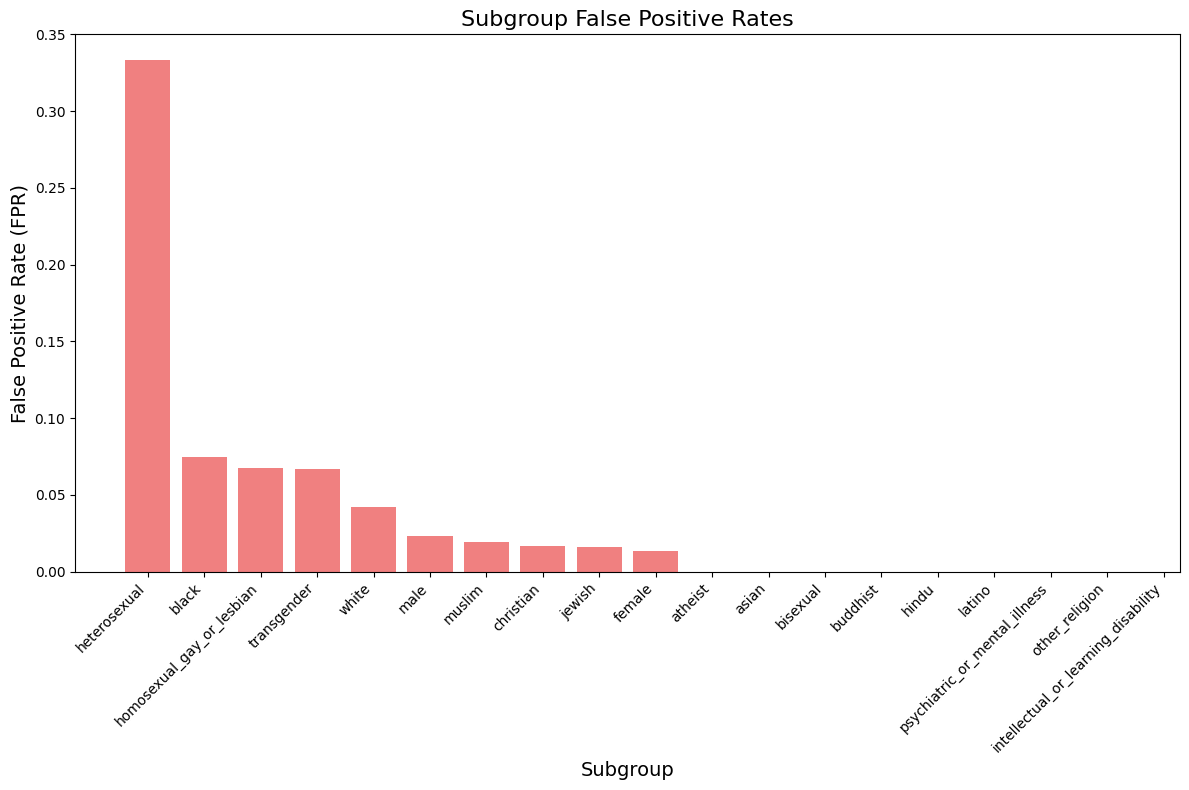

In [29]:
import matplotlib.pyplot as plt

# Plot subgroup FPRs
plt.figure(figsize=(12, 8))
plt.bar(subgroup_fpr_df['Subgroup'], subgroup_fpr_df['FPR'], color='lightcoral')
plt.xlabel('Subgroup', fontsize=14)
plt.ylabel('False Positive Rate (FPR)', fontsize=14)
plt.title('Subgroup False Positive Rates', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [52]:
# Directory to save the model
output_dir = "bert_model_checkpoint"

# Save the model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to '{output_dir}'")

Model and tokenizer saved to 'bert_model_checkpoint'


In [35]:
# Run 2 more epoch for up_sampled
epochs = 2
second_model.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 2}/{epochs + 1}")
    loop = tqdm(upsampled_loader, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = second_model(**batch)
        loss = outputs.loss
        loss.backward()
        second_optimizer.step()
        second_lr_scheduler.step()
        second_optimizer.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())

Epoch 2/3


Training:   0%|          | 0/10978 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 10978/10978 [29:16<00:00,  6.25it/s, loss=0.0105]  


Epoch 3/3


Training: 100%|██████████| 10978/10978 [29:16<00:00,  6.25it/s, loss=0.00317] 


In [36]:
# Evaluation loop
second_model.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = model(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))

# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions.csv", index=False)
print("Validation predictions saved to 'val_with_predictions.csv'.")

Evaluating:   0%|          | 0/2257 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 2257/2257 [02:00<00:00, 18.69it/s]


              precision    recall  f1-score   support

   Non-Toxic       0.96      0.99      0.97     33207
       Toxic       0.78      0.51      0.61      2891

    accuracy                           0.95     36098
   macro avg       0.87      0.75      0.79     36098
weighted avg       0.94      0.95      0.94     36098

Validation predictions saved to 'val_with_predictions.csv'.


In [37]:
# Load original dataset
original_data = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Load validation predictions
val_predictions = pd.read_csv("val_with_predictions.csv")
# Merge validation predictions with the original dataset
merged_data = val_predictions.merge(original_data, on="id", how="left")
# Define subgroup columns
subgroups = [
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white"
]

In [38]:
# Ensure labels are numeric
merged_data['true_label'] = merged_data['true_label'].map({"non-toxic": 0, "toxic": 1})
merged_data['predicted_label'] = merged_data['predicted_label'].map({"non-toxic": 0, "toxic": 1})

# Check the counts of members in each subgroup
subgroup_counts = merged_data[subgroups].sum()
# print(subgroup_counts)

# Debug accuracy for the 'asian' subgroup
asian_data = merged_data[merged_data['asian'] == 1]
print("Number of samples in 'asian' subgroup:", len(asian_data))
print("Correctly predicted samples:", (asian_data['true_label'] == asian_data['predicted_label']).sum())

# Recalculate subgroup accuracies
subgroup_accuracies = {}

for subgroup in subgroups:
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    if not subgroup_data.empty:
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert to DataFrame
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]
print(subgroup_accuracies_df)

Number of samples in 'asian' subgroup: 19
Correctly predicted samples: 0
                               Subgroup  Accuracy  Support
0                                 asian  0.789474       19
1                               atheist  1.000000        6
2                              bisexual  1.000000        1
3                                 black  0.777778      171
4                              buddhist  1.000000        1
5                             christian  0.910448      335
6                                female  0.907251      593
7                          heterosexual  0.571429        7
8                                 hindu  1.000000        3
9             homosexual_gay_or_lesbian  0.780000      100
10  intellectual_or_learning_disability       NaN        0
11                               jewish  0.891892       74
12                               latino  0.866667       15
13                                 male  0.893462      413
14                               muslim  0

In [30]:
# Up sample for JTT and choose up_sample_weight to be 10 this time

up_sample_weight_10 = 10
indices = list(range(len(train_dataset))) + up_sample_weight_10 * error_indices
copy_old = copy.deepcopy(train_dataset)
upsampled_loader_weight_10 = DataLoader(copy_old, batch_size = 16, sampler = CustomIndicesSampler(indices,True))

# Train with the upsampled loader
second_model_weight_10 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
second_model_weight_10.to(device)

# Optimizer and learning rate scheduler
second_optimizer_weight_10 = AdamW(second_model_weight_10.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
second_num_training_steps_weight_10 = len(upsampled_loader_weight_10) * 3  # Assuming 3 epochs
second_lr_scheduler_weight_10 = get_scheduler("linear", optimizer=second_optimizer_weight_10, num_warmup_steps=0, num_training_steps=second_num_training_steps_weight_10)

# Training loop
epochs = 1
second_model_weight_10.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(upsampled_loader_weight_10, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = second_model_weight_10(**batch)
        loss = outputs.loss
        loss.backward()
        second_optimizer_weight_10.step()
        second_lr_scheduler_weight_10.step()
        second_optimizer_weight_10.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/toxic/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training:   0%|          | 0/12932 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 12932/12932 [41:05<00:00,  5.25it/s, loss=0.0579]  


In [32]:
from sklearn.metrics import classification_report

# Evaluation loop
second_model_weight_10.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k not in ["id","row_index"]}
        outputs = second_model_weight_10(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))

# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions.csv", index=False)
print("Validation predictions saved to 'val_with_predictions.csv'.")

Evaluating:   0%|          | 0/2257 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 2257/2257 [02:00<00:00, 18.74it/s]


              precision    recall  f1-score   support

   Non-Toxic       0.96      0.97      0.97     33207
       Toxic       0.65      0.56      0.60      2891

    accuracy                           0.94     36098
   macro avg       0.81      0.76      0.78     36098
weighted avg       0.94      0.94      0.94     36098

Validation predictions saved to 'val_with_predictions.csv'.
                               Subgroup  Accuracy  Support
0                                 asian       0.0       19
1                               atheist       0.0        6
2                              bisexual       0.0        1
3                                 black       0.0      171
4                              buddhist       0.0        1
5                             christian       0.0      335
6                                female       0.0      593
7                          heterosexual       0.0        7
8                                 hindu       0.0        3
9             homosexua

In [33]:
# Load original dataset
original_data = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Load validation predictions
val_predictions = pd.read_csv("val_with_predictions.csv")
# Merge validation predictions with the original dataset
merged_data = val_predictions.merge(original_data, on="id", how="left")
# Define subgroup columns
subgroups = [
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white"
]
# Initialize dictionary to store results
subgroup_accuracies = {}

# Calculate accuracy for each subgroup
for subgroup in subgroups:
    # Filter rows where the subgroup column is 1 (indicating membership in the subgroup)
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate accuracy: (correct predictions / total predictions for the subgroup)
        correct_predictions = (subgroup_data['true_label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        # Handle cases where there are no members in the subgroup
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert results to a DataFrame for better visualization
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]

# Sort the DataFrame by accuracy
subgroup_accuracies_df = subgroup_accuracies_df.sort_values(by="Accuracy", ascending=False)

# Display the results
print(subgroup_accuracies_df)

# Save the results to a CSV file
subgroup_accuracies_df.to_csv("subgroup_accuracies.csv", index=False)
print("Subgroup accuracies saved to 'subgroup_accuracies.csv'.")

# Check the unique values of true_label and predicted_label
print("Unique values in true_label:", merged_data['true_label'].unique())
print("Unique values in predicted_label:", merged_data['predicted_label'].unique())

# Ensure labels are numeric
merged_data['true_label'] = merged_data['true_label'].map({"non-toxic": 0, "toxic": 1})
merged_data['predicted_label'] = merged_data['predicted_label'].map({"non-toxic": 0, "toxic": 1})

# Check the counts of members in each subgroup
subgroup_counts = merged_data[subgroups].sum()
print(subgroup_counts)

# Debug accuracy for the 'asian' subgroup
asian_data = merged_data[merged_data['asian'] == 1]
print("Number of samples in 'asian' subgroup:", len(asian_data))
print("Correctly predicted samples:", (asian_data['true_label'] == asian_data['predicted_label']).sum())

                               Subgroup  Accuracy  Support
0                                 asian       0.0       19
1                               atheist       0.0        6
2                              bisexual       0.0        1
3                                 black       0.0      171
4                              buddhist       0.0        1
5                             christian       0.0      335
6                                female       0.0      593
7                          heterosexual       0.0        7
8                                 hindu       0.0        3
9             homosexual_gay_or_lesbian       0.0      100
11                               jewish       0.0       74
12                               latino       0.0       15
13                                 male       0.0      413
14                               muslim       0.0      266
18                       other_religion       0.0        2
21        psychiatric_or_mental_illness       0.0       

In [34]:
# Recalculate subgroup accuracies
subgroup_accuracies = {}

for subgroup in subgroups:
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    if not subgroup_data.empty:
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert to DataFrame
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]
print(subgroup_accuracies_df)

# Initialize a dictionary to store subgroup FPRs
subgroup_fpr = {}

for subgroup in subgroups:
    # Filter rows where the subgroup column is 1
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate False Positives (FP) and True Negatives (TN)
        fp = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 1)).sum()
        tn = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 0)).sum()
        
        # Calculate FPR: FP / (FP + TN)
        actual_negatives = fp + tn
        fpr = fp / actual_negatives if actual_negatives > 0 else None
        subgroup_fpr[subgroup] = {
            "FPR": fpr,
            "Support": actual_negatives
        }
    else:
        # Handle cases where there are no members of the subgroup
        subgroup_fpr[subgroup] = {
            "FPR": None,
            "Support": 0
        }

# Convert to DataFrame for visualization
subgroup_fpr_df = pd.DataFrame.from_dict(subgroup_fpr, orient="index")
subgroup_fpr_df.reset_index(inplace=True)
subgroup_fpr_df.columns = ["Subgroup", "FPR", "Support"]

# Sort by FPR
subgroup_fpr_df = subgroup_fpr_df.sort_values(by="FPR", ascending=False)

# Display the results
print(subgroup_fpr_df)

# Save results to a CSV
subgroup_fpr_df.to_csv("subgroup_fpr.csv", index=False)
print("Subgroup FPR saved to 'subgroup_fpr.csv'.")

                               Subgroup  Accuracy  Support
0                                 asian  0.736842       19
1                               atheist  1.000000        6
2                              bisexual  1.000000        1
3                                 black  0.742690      171
4                              buddhist  1.000000        1
5                             christian  0.895522      335
6                                female  0.897133      593
7                          heterosexual  1.000000        7
8                                 hindu  1.000000        3
9             homosexual_gay_or_lesbian  0.740000      100
10  intellectual_or_learning_disability       NaN        0
11                               jewish  0.824324       74
12                               latino  0.866667       15
13                                 male  0.886199      413
14                               muslim  0.785714      266
15                     other_disability       NaN       

In [40]:
# Up sample for JTT and choose up_sample_weight to be 7 this time

up_sample_weight_7 = 7
indices = list(range(len(train_dataset))) + up_sample_weight_7 * error_indices
copy_old_7 = copy.deepcopy(train_dataset)
upsampled_loader_weight_7 = DataLoader(copy_old_7, batch_size = 16, sampler = CustomIndicesSampler(indices,True))

# Train with the upsampled loader
second_model_weight_7 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
second_model_weight_7.to(device)

# Optimizer and learning rate scheduler
second_optimizer_weight_7 = AdamW(second_model_weight_7.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
second_num_training_steps_weight_7 = len(upsampled_loader_weight_7) * 3  # Assuming 3 epochs
second_lr_scheduler_weight_7 = get_scheduler("linear", optimizer=second_optimizer_weight_7, num_warmup_steps=0, num_training_steps=second_num_training_steps_weight_7)

# Training loop
epochs = 1
second_model_weight_7.train()

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    loop = tqdm(upsampled_loader_weight_7, desc="Training", leave=True)
    for batch in loop:
        # Move inputs to the device
        batch = {k: v.to(device) for k, v in batch.items() if k not in ['id', 'row_index']}
        outputs = second_model_weight_7(**batch)
        loss = outputs.loss
        loss.backward()
        second_optimizer_weight_7.step()
        second_lr_scheduler_weight_7.step()
        second_optimizer_weight_7.zero_grad()
        
        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1


Training:   0%|          | 0/11760 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Training: 100%|██████████| 11760/11760 [31:21<00:00,  6.25it/s, loss=0.000789]


In [41]:
from sklearn.metrics import classification_report

# Evaluation loop
second_model_weight_7.eval()
val_predictions, val_true_labels, val_ids = [], [], []  # Include val_ids to track original IDs

with torch.no_grad():
    loop = tqdm(val_loader, desc="Evaluating", leave=True)
    for batch in loop:
        # Move inputs to the device, exclude 'id'
        batch_inputs = {k: v.to(device) for k, v in batch.items() if k not in ["id","row_index"]}
        outputs = second_model_weight_7(**batch_inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Collect predictions, true labels, and IDs
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(batch['labels'].cpu().numpy())
        val_ids.extend(batch['id'].cpu().numpy())  # Track the original IDs

# Generate classification report
print(classification_report(val_true_labels, val_predictions, target_names=["Non-Toxic", "Toxic"]))


Evaluating:   0%|          | 0/2257 [00:00<?, ?it/s]/var/tmp/ipykernel_4045/2689955798.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Evaluating: 100%|██████████| 2257/2257 [02:02<00:00, 18.49it/s]

              precision    recall  f1-score   support

   Non-Toxic       0.97      0.95      0.96     33207
       Toxic       0.55      0.66      0.60      2891

    accuracy                           0.93     36098
   macro avg       0.76      0.81      0.78     36098
weighted avg       0.94      0.93      0.93     36098



In [42]:
# Add predictions and true labels to the validation DataFrame for analysis
val_data['id'] = val_ids
val_data['true_label'] = val_true_labels
val_data['predicted_label'] = val_predictions
val_data['predicted_label'] = val_data['predicted_label'].map({0: "non-toxic", 1: "toxic"})

# Save validation results
val_data.to_csv("val_with_predictions.csv", index=False)
print("Validation predictions saved to 'val_with_predictions.csv'.")

# Load original dataset
original_data = pd.read_csv(os.path.join(Data_dir, "train.csv"))

# Load validation predictions
val_predictions = pd.read_csv("val_with_predictions.csv")
# Merge validation predictions with the original dataset
merged_data = val_predictions.merge(original_data, on="id", how="left")
# Define subgroup columns
subgroups = [
    "asian", "atheist", "bisexual", "black", "buddhist", "christian",
    "female", "heterosexual", "hindu", "homosexual_gay_or_lesbian",
    "intellectual_or_learning_disability", "jewish", "latino", "male",
    "muslim", "other_disability", "other_gender", "other_race_or_ethnicity",
    "other_religion", "other_sexual_orientation", "physical_disability",
    "psychiatric_or_mental_illness", "transgender", "white"
]
# Initialize dictionary to store results
subgroup_accuracies = {}

# Calculate accuracy for each subgroup
for subgroup in subgroups:
    # Filter rows where the subgroup column is 1 (indicating membership in the subgroup)
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate accuracy: (correct predictions / total predictions for the subgroup)
        correct_predictions = (subgroup_data['true_label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        # Handle cases where there are no members in the subgroup
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert results to a DataFrame for better visualization
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]

# Sort the DataFrame by accuracy
subgroup_accuracies_df = subgroup_accuracies_df.sort_values(by="Accuracy", ascending=False)

# Display the results
#print(subgroup_accuracies_df)

# Save the results to a CSV file
subgroup_accuracies_df.to_csv("subgroup_accuracies.csv", index=False)
print("Subgroup accuracies saved to 'subgroup_accuracies.csv'.")

# Check the unique values of true_label and predicted_label
print("Unique values in true_label:", merged_data['true_label'].unique())
print("Unique values in predicted_label:", merged_data['predicted_label'].unique())

# Ensure labels are numeric
merged_data['true_label'] = merged_data['true_label'].map({"non-toxic": 0, "toxic": 1})
merged_data['predicted_label'] = merged_data['predicted_label'].map({"non-toxic": 0, "toxic": 1})

# Check the counts of members in each subgroup
subgroup_counts = merged_data[subgroups].sum()
# print(subgroup_counts)

# Debug accuracy for the 'asian' subgroup
asian_data = merged_data[merged_data['asian'] == 1]
print("Number of samples in 'asian' subgroup:", len(asian_data))
print("Correctly predicted samples:", (asian_data['true_label'] == asian_data['predicted_label']).sum())


Validation predictions saved to 'val_with_predictions.csv'.
Subgroup accuracies saved to 'subgroup_accuracies.csv'.
Unique values in true_label: [0 1]
Unique values in predicted_label: ['non-toxic' 'toxic']
Number of samples in 'asian' subgroup: 19
Correctly predicted samples: 0


In [43]:
# Recalculate subgroup accuracies
subgroup_accuracies = {}

for subgroup in subgroups:
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    if not subgroup_data.empty:
        correct_predictions = (subgroup_data['label'] == subgroup_data['predicted_label']).sum()
        total_predictions = len(subgroup_data)
        accuracy = correct_predictions / total_predictions
        subgroup_accuracies[subgroup] = {
            "accuracy": accuracy,
            "support": total_predictions
        }
    else:
        subgroup_accuracies[subgroup] = {
            "accuracy": None,
            "support": 0
        }

# Convert to DataFrame
subgroup_accuracies_df = pd.DataFrame.from_dict(subgroup_accuracies, orient="index")
subgroup_accuracies_df.reset_index(inplace=True)
subgroup_accuracies_df.columns = ["Subgroup", "Accuracy", "Support"]
print(subgroup_accuracies_df)

# Initialize a dictionary to store subgroup FPRs
subgroup_fpr = {}

for subgroup in subgroups:
    # Filter rows where the subgroup column is 1
    subgroup_data = merged_data[merged_data[subgroup] == 1]
    
    if not subgroup_data.empty:
        # Calculate False Positives (FP) and True Negatives (TN)
        fp = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 1)).sum()
        tn = ((subgroup_data['label'] == 0) & (subgroup_data['predicted_label'] == 0)).sum()
        
        # Calculate FPR: FP / (FP + TN)
        actual_negatives = fp + tn
        fpr = fp / actual_negatives if actual_negatives > 0 else None
        subgroup_fpr[subgroup] = {
            "FPR": fpr,
            "Support": actual_negatives
        }
    else:
        # Handle cases where there are no members of the subgroup
        subgroup_fpr[subgroup] = {
            "FPR": None,
            "Support": 0
        }

# Convert to DataFrame for visualization
subgroup_fpr_df = pd.DataFrame.from_dict(subgroup_fpr, orient="index")
subgroup_fpr_df.reset_index(inplace=True)
subgroup_fpr_df.columns = ["Subgroup", "FPR", "Support"]

# Sort by FPR
subgroup_fpr_df = subgroup_fpr_df.sort_values(by="FPR", ascending=False)

# Display the results
print(subgroup_fpr_df)

# Save results to a CSV
subgroup_fpr_df.to_csv("subgroup_fpr.csv", index=False)
print("Subgroup FPR saved to 'subgroup_fpr.csv'.")

                               Subgroup  Accuracy  Support
0                                 asian  0.736842       19
1                               atheist  0.833333        6
2                              bisexual  1.000000        1
3                                 black  0.678363      171
4                              buddhist  1.000000        1
5                             christian  0.883582      335
6                                female  0.878583      593
7                          heterosexual  0.714286        7
8                                 hindu  1.000000        3
9             homosexual_gay_or_lesbian  0.780000      100
10  intellectual_or_learning_disability       NaN        0
11                               jewish  0.756757       74
12                               latino  0.800000       15
13                                 male  0.876513      413
14                               muslim  0.744361      266
15                     other_disability       NaN       